
# People Movement Patterns Study

## README

Para ejecutar este proyecto es necesario tener instalado al menos Python 3.9 y Poetry

- Instalar Poetry: https://python-poetry.org/docs/#installation
- Instalar dependencias: poetry install

## Estructura del proyecto

- `data`: Contiene los datos de entrada y salida del proyecto
- `exploration`: Contiene los notebooks de exploración de datos
- `apps`: Contiene el código necesario para ejecutar la aplicación

La forma sencilla de ejecutar la aplicación es mediante el comando `poetry run python apps/<application>`

## Aplicaciones

- `landing_phase`: Encargada de transformar los datos de entrada a un formato apto para manipularlos en el siguiente paso
- `transformation_phase`: Esta etapa consolida los datos de entrada y los transforma en un formato apto para ser analizados
- `mean_trips`: Servicio que permite obtener el promedio de viajes por día de la semana dado un bounding box

## Ejecución de la aplicación

- `landing_phase`: `poetry run python apps/landing_phase`
- `transformation_phase`: `poetry run python apps/transformation_phase`
- `mean_trips`: `poetry run python apps/mean_trips/main.py`

Las aplicaciones deben ser ejecutadas en el orden indicado para que el resultado sea el esperado (landing_phase -> transformation_phase -> mean_trips) esto es dado que la responsabilidad de crear las tablas necesarias para la aplicación `mean_trips` es de la aplicación `transformation_phase` y no de la aplicación `landing_phase`.


## 1. Automated processes to ingest and store data on demand

### a. Similar trips are grouped together
> group rule (origin, destination, time of day)

Esto describe de forma no optimizada para trabajo en batches la funcionalidad de `apps/transformation_phase/transformation_phase/infrastructure/api/cluster_api.py` y `apps/transformation_phase/transformation_phase/infrastructure/storage/sql_output_storage.py`. El objetivo es que el código sea lo más legible posible, y que sea fácil de entender qué hace cada parte del código. Pero para ver la version optimizada para trabajo en batches, ver los archivos mencionados.

In [21]:
import pandas as pd
from numpy import radians

columns=['region','origin_coord','destination_coord','datetime','datasource']
# Read the data
df = pd.read_csv('../data/landing/trips.csv', sep=',')

In [22]:
import numpy as np
np.unique(df['region'])

array(['Hamburg', 'Prague', 'Turin'], dtype=object)

Trabajamos por region dado que nuestra métrica final esta particionada por este campo. Por lo cual nunca tendra sentido procesar un batch mas grande que una region.

In [23]:

df = df[df['region'] == 'Turin']
df['datetime'] = pd.to_datetime(df['datetime'])
df.head()

,region,origin_coord,destination_coord,datetime,datasource
1,Turin,POINT (7.672837913286881 44.9957109242058),POINT (7.720368637535126 45.06782385393849),2018-05-21 02:54:04,baba_car
3,Turin,POINT (7.541509189114433 45.09160503827746),POINT (7.74528653441973 45.02628598341506),2018-05-06 09:49:16,bad_diesel_vehicles
4,Turin,POINT (7.614078119815749 45.13433106465422),POINT (7.527497142312585 45.03335051325654),2018-05-23 12:45:54,pt_search_app
7,Turin,POINT (7.560785081962462 45.01901608530191),POINT (7.583568695710608 45.10526898076209),2018-05-06 00:00:44,cheap_mobile
8,Turin,POINT (7.702418079996892 45.05754972796922),POINT (7.623229346744799 44.99969774086024),2018-05-14 02:07:30,cheap_mobile


Aquí nose si es el standard pero dado un punto `POINT (Lat Lon)` me di cuenta viendo los mapas y los datos que para todas las region la latitud y la longitud estan en el orden inverso, es decir `POINT (Lon Lat)` y no `POINT (Lat Lon)` como se espera. Por lo tanto, en la transformación de los datos de entrada se debe invertir el orden de las columnas.

In [24]:
clean_df = df.loc[:, ['origin_coord', 'destination_coord', 'datetime']]


# Separate point coordinates
splitted_origin = clean_df['origin_coord'].str.strip(' ').str.split(pat=' ', expand=True)
splitted_destination = clean_df['destination_coord'].str.strip(' ').str.split(pat=' ', expand=True)
clean_df['origin_lon'] = splitted_origin[1].str.replace('(','', regex=False).astype(float)
clean_df['origin_lat'] = splitted_origin[2].str.replace(')','', regex=False).astype(float)
clean_df['destination_lon'] = splitted_destination[1].str.replace('(','', regex=False).astype(float)
clean_df['destination_lat'] = splitted_destination[2].str.replace(')','', regex=False).astype(float)
clean_df.drop(['origin_coord', 'destination_coord'], axis=1, inplace=True)


# Get hour of the day
clean_df['hour'] = clean_df['datetime'].dt.hour
clean_df.pop('datetime')
classification_df = clean_df.copy()
classification_df.pop('hour')
classification_df['destination_lat'] = radians(clean_df['destination_lat'])
classification_df['destination_lon'] = radians(clean_df['destination_lon'])
classification_df['origin_lat'] = radians(clean_df['origin_lat'])
classification_df['origin_lon'] = radians(clean_df['origin_lon'])

classification_df.head()


,origin_lon,origin_lat,destination_lon,destination_lat
1,0.133916,0.785323,0.134746,0.786582
3,0.131624,0.786997,0.135181,0.785857
4,0.132891,0.787743,0.131380,0.785980
7,0.131961,0.785730,0.132358,0.787235
8,0.134433,0.786403,0.133050,0.785393


In [25]:
import numpy as np
# https://kanoki.org/2019/12/27/how-to-calculate-distance-in-python-and-pandas-using-scipy-spatial-and-distance-functions/

def haversine_vectorize(lon1, lat1, lon2, lat2):

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return km

Aqui agrego la distancia entre el origen y el destino, para poder identificar los viajes que son similares. Para esto se utiliza la formula de Haversine. La distancia se calcula en kilometros.

In [26]:
classification_df["harversine_distance"] = haversine_vectorize(
    classification_df['origin_lon'],
    classification_df['origin_lat'],
    classification_df['destination_lon'],
    classification_df['destination_lat']
    )

Luego para cada viaje genero un modelo de clusterizacion utilizando una Bayesian Gaussian Mixture, pues permite identificar automaticamente la cantidad de clusters necesarios. El modelo tiene que ser local a los datos procesados dado el principio de localidad (Datos recibidos en tiempos similares seran mas similares que datos recibidos en tiempos diferentes). Para esto se utiliza el modelo `apps/transformation_phase/transformation_phase/infrastructure/api/cluster_api.py` que se encarga de generar el modelo de clusterizacion dada una division por hora y region de los datos de entrada. El modelo no se guarda en ningun lado, solo se utiliza para generar los clusters de manera dinamica mediante el procesamiento del stream de datos.

In [27]:
from sklearn.mixture import BayesianGaussianMixture

model = BayesianGaussianMixture(n_components=20, covariance_type='spherical', max_iter=1000)

# Fit the model

model.fit(classification_df)

BayesianGaussianMixture(covariance_type='spherical', max_iter=1000,
                        n_components=20)

In [28]:
import numpy as np
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

classified_trips = classification_df.copy()
classified_trips = DataFrame(classified_trips.values, columns=classified_trips.columns, index=classified_trips.index)

classified_trips['cluster'] = model.predict(classification_df)
print('Number of clusters: {}'.format(len(classified_trips['cluster'].unique())))
classified_trips.head()

Number of clusters: 3


,origin_lon,origin_lat,destination_lon,destination_lat,harversine_distance,cluster
1,0.133916,0.785323,0.134746,0.786582,8.840285,2
3,0.131624,0.786997,0.135181,0.785857,17.565658,16
4,0.132891,0.787743,0.131380,0.785980,13.117580,16
7,0.131961,0.785730,0.132358,0.787235,9.750268,2
8,0.134433,0.786403,0.133050,0.785393,8.944810,2


In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(classification_df)
classified_trips_pca = pca.transform(classification_df)
classified_trips_pca = DataFrame(classified_trips_pca, columns=['x', 'y'], index=classification_df.index)

classified_trips_pca['cluster'] = classified_trips['cluster']
classified_trips_pca.head()

,x,y,cluster
1,-0.206935,-0.001406,2
3,8.518438,-0.001048,16
4,4.070360,0.002366,16
7,0.703048,0.001381,2
8,-0.102410,0.000256,2


En la siguiente celda se muestra como se genera el modelo de clusterizacion para una region y una hora en particular.

Como se puede observar los puntos son clasificados en 3 clusters bien definidos.

<AxesSubplot: xlabel='x', ylabel='y'>

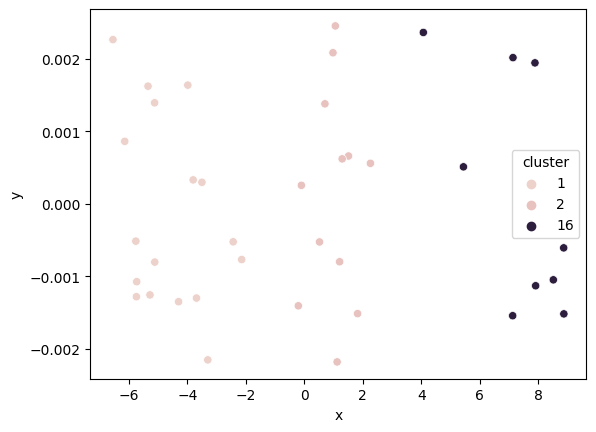

In [30]:
from seaborn import scatterplot
scatterplot(x='x', y='y', hue='cluster', data=classified_trips_pca)

In [31]:
df['datetime'] = df['datetime'].view('int64')/ 10**9

Agrupo por cluster (viajes similares), region y hora. Esto según el criterio de agrupación previamente definido. 

In [32]:
datasource = df.loc[:, ['datasource']]
base_data = classified_trips.loc[:,['cluster']].join(df).join(clean_df).groupby(['cluster', 'region', 'hour'])[
    ['origin_lat', 'origin_lon', 'destination_lat', 'destination_lon', 'datetime']
].mean()

base_data.head()

origin_lat  origin_lon  destination_lat  destination_lon  \
cluster region hour                                                             
1       Turin  0      44.996386    7.551998        45.013469         7.531353   
               4      45.059853    7.598069        45.064887         7.656904   
               5      45.087936    7.621867        45.096293         7.558481   
               6      45.086819    7.679991        45.081787         7.655900   
               7      45.104444    7.720378        45.128276         7.695048   

                         datetime  
cluster region hour                
1       Turin  0     1.525221e+09  
               4     1.526618e+09  
               5     1.526795e+09  
               6     1.527143e+09  
               7     1.525504e+09

In [33]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(df['datasource'].values.reshape(-1,1))
encoded_categories = enc.transform(df['datasource'].values.reshape(-1,1)).toarray()

In [34]:
encoded_categories.sum(axis=0)

array([ 5.,  8., 10.,  4., 11.])

In [35]:
enc.categories_

[array(['baba_car', 'bad_diesel_vehicles', 'cheap_mobile', 'funny_car',
        'pt_search_app'], dtype=object)]

Aquí agrupo las fuentes de información, a pesar que no son necesarias para la métrica final, preferí no perder información y agruparlas para poder analizarlas en el futuro.

In [36]:
source = classified_trips.loc[:,['cluster']].join(df).join(clean_df).loc[:, ["cluster", "region", "hour"]].join(
    pd.DataFrame(encoded_categories, index=df.index)
).groupby(["cluster", "region", "hour"]).sum()

for datasource in range(enc.categories_[0].shape[0]):
    source.rename(columns={datasource: enc.categories_[0][datasource]}, inplace=True)
    source[enc.categories_[0][datasource]] = source[enc.categories_[0][datasource]].astype(int)

source.head()


baba_car  bad_diesel_vehicles  cheap_mobile  funny_car  \
cluster region hour                                                           
1       Turin  0            0                    0             0          0   
               4            0                    0             0          2   
               5            1                    0             0          0   
               6            0                    1             1          0   
               7            1                    0             0          0   

                     pt_search_app  
cluster region hour                 
1       Turin  0                 1  
               4                 0  
               5                 0  
               6                 1  
               7                 0

In [37]:
final_data = base_data.join(source).reset_index().drop('cluster', axis=1)
print(final_data.shape)
final_data['datetime'] = pd.to_datetime(final_data['datetime'], unit='s')
final_data.head()

(31, 12)


,region,hour,origin_lat,origin_lon,destination_lat,destination_lon,datetime,baba_car,bad_diesel_vehicles,cheap_mobile,funny_car,pt_search_app
0,Turin,0,44.996386,7.551998,45.013469,7.531353,2018-05-02 00:22:18.000,0,0,0,0,1
1,Turin,4,45.059853,7.598069,45.064887,7.656904,2018-05-18 04:26:33.500,0,0,0,2,0
2,Turin,5,45.087936,7.621867,45.096293,7.558481,2018-05-20 05:39:56.000,1,0,0,0,0
3,Turin,6,45.086819,7.679991,45.081787,7.655900,2018-05-24 06:22:27.000,0,1,1,0,1
4,Turin,7,45.104444,7.720378,45.128276,7.695048,2018-05-05 07:05:01.000,1,0,0,0,0


Lo anterior es equivalente a llamar estos 2 procesos en cadena

Transformación de CSV a parquet y particionado por region
Equivalente a llamar a:

- `python apps/landing_phase/`

In [38]:
import sys

sys.path.append('../apps/landing_phase/')

from landing_phase.constants.storage import ProtocolType
from landing_phase.infrastructure.api.local_notifications import LocalNotifications
from landing_phase.infrastructure.storage.input_storage import InputFileStorage
from landing_phase.infrastructure.storage.output_storage import OutputFileStorage
from landing_phase.use_cases.transform_use_case import TransformUseCase

if __name__ == "__main__":
    from pathlib import Path

    bucket_path = str(Path('..').resolve().absolute() / "data")

    use_cases = {
        "transform": TransformUseCase(
            input_storage=InputFileStorage(protocol=ProtocolType.LOCAL),
            output_storage=OutputFileStorage(
                bucket_name=bucket_path, protocol=ProtocolType.LOCAL
            ),
            notifications_api=LocalNotifications(),
        )
    }

    use_case = use_cases.get("transform")

    if use_case:
        use_case.transform(
            bucket_path,
            "trips.csv",
        )

INFO:landing_phase.infrastructure.api.local_notifications:{"code": "TRANSFORMING", "message": "Received file", "file": "landing/trips.csv"}
INFO:landing_phase.infrastructure.api.local_notifications:{"code": "TRANSFORMED", "message": "Chunk of size 0.004128 MB transformed", "file": "processed\\source=trips_transformed\\hash=3ef280e4daee4be5d375e2c4b0c3c17b"}


Clusterización de datos y guardado en Base de datos SQL compatible con sqlalchemy
Equivalente a llamar a:

- `python apps/transformation_phase/`

In [39]:
import sys

sys.path.append('../apps/transformation_phase/')

from sqlalchemy.engine import create_engine
from transformation_phase.constants.storage import ProtocolType
from transformation_phase.infrastructure.api.cluster_api import (
    ClusterClassificationAPI,
)
from transformation_phase.infrastructure.storage.input_storage import (
    InputFileStorage,
)
from transformation_phase.infrastructure.storage.sql_batch_log_storage import (
    SQLBatchLogStorage,
)
from transformation_phase.infrastructure.storage.sql_output_storage import (
    SQLTripsOutputStorage,
)
from transformation_phase.infrastructure.api.local_notifications import (
    LocalNotifications,
)
from transformation_phase.use_cases.clasify_use_case import ClassifyUseCase
from transformation_phase.use_cases.transform_use_case import TransformUseCase

DB_CONNECTION_URL = "sqlite:///../data/processed.db"

if __name__ == "__main__":
    from pathlib import Path

    bucket_path = Path('..').resolve().absolute() / "data"
    example_file = (
        Path("source=trips_transformed")
        # / "hash=8ee3e469366db947933d5d13ba355d26"
        # / "region=Hamburg"
        # / "33ba9dc7dd3e47a19163be37b09c6df3-0.parquet"
    )

    use_cases = {
        "transform": TransformUseCase(
            output_storage=SQLTripsOutputStorage(
                engine=create_engine(
                    DB_CONNECTION_URL,
                ),
            ),
            log_storage=SQLBatchLogStorage(
                engine=create_engine(
                    DB_CONNECTION_URL,
                ),
            ),
            notifications_api=LocalNotifications(),
        ),
        "classify": ClassifyUseCase(
            input_storage=InputFileStorage(protocol=ProtocolType.LOCAL),
            clustering_api=ClusterClassificationAPI(),
            notifications_api=LocalNotifications(),
        ),
    }

    classify_use_case = use_cases["classify"]
    transform_use_case = use_cases["transform"]

    result = classify_use_case.classify(
        bucket=str(bucket_path), name=str(example_file)
    )

    for output_file in result:
        transform_use_case.transform(output_file)


INFO:transformation_phase.infrastructure.api.local_notifications:{"code": "CLASSIFYING", "message": "Received file", "file": "processed/source=trips_transformed"}
INFO:transformation_phase.infrastructure.api.local_notifications:{"code": "TRAINED", "message": "Chunk of size 0.001248 MB classified", "file": "processed/source=trips_transformed"}
INFO:transformation_phase.infrastructure.api.local_notifications:{"code": "TRAINED", "message": "Chunk of size 0.001488 MB classified", "file": "processed/source=trips_transformed"}
c:\Users\Gabriel Faundez\AppData\Local\pypoetry\Cache\virtualenvs\movement-patterns-hAuNFaCb-py3.9\lib\site-packages\sklearn\mixture\_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
INFO:transformation_phase.infrastructure.api.local_notifications:{"code": "TRAINED", "message": "Chunk of size 0.001648 MB classified", "file": "processed/source=trips

## 2. A service to query the data

### a. Get a weekly mean of trips defined by a bounding box

Finalmente este servicio queda definido por una sola query ejecutada en una **Cloud Function**, a continuación un ejemplo de como se ejecuta la query.

```sql
SELECT strftime('%W', datetime) WeekNumber, count(*) as trips_per_week
  from trips as t
  where region == 'Hamburg'
  and origin_lat between 53.4 and 53.7
  and origin_lon between 9.5 and 10.2
  and destination_lat between 53.4 and 53.7
  and destination_lon between 9.5 and 10.2
  GROUP by WeekNumber;
```

El servicio esta definido en `apps/mean_trips/mean_trips/infrastructure/repositories/trips_weekly_metric_sql_repository.py` y se ejecuta a través de un caso de uso desde el main `apps/mean_trips/main.py`.

In [40]:
import sys

sys.path.append('../apps/mean_trips/')

import logging
from sqlalchemy import create_engine
from mean_trips.domain.models.trip_weely_metric import TripWeeklyMetric

from mean_trips.infrastructure.repositories.trips_weekly_metric_sql_repository import (
    TripWeeklyMetricSQLRepository,
)
from mean_trips.use_cases.trips_weekly_metric_use_case import (
    TripsWeeklyMetricUseCase,
)


if __name__ == "__main__":

    payload: TripWeeklyMetric = {
        "region": "Hamburg",
        "min_lat": 53.4,
        "max_lat": 53.7,
        "min_lon": 9.5,
        "max_lon": 10.2,
    }

    use_cases = {
        "trips_weekly": TripsWeeklyMetricUseCase(
            repository=TripWeeklyMetricSQLRepository(
                engine=create_engine(
                    "sqlite:///../data/processed.db", echo=False
                ),
            ),
        )
    }

    metric_use_case = use_cases["trips_weekly"]
    result = metric_use_case.execute(
        entity=payload,
    )
    logging.info(result)


INFO:mean_trips.infrastructure.repositories.trips_weekly_metric_sql_repository:Executing query: 
        with weekly_trips as (
            SELECT strftime('%W', datetime) WeekNumber, count(*) as trips_per_week
            from trips as t
            where region == 'Hamburg'
            and origin_lat between 53.4 and 53.7
            and origin_lon between 9.5 and 10.2
            and destination_lat between 53.4 and 53.7
            and destination_lon between 9.5 and 10.2
            GROUP by WeekNumber
        )
        SELECT AVG(trips_per_week) from weekly_trips;
        
INFO:root:{'mean_trips': 4.0, 'region': 'Hamburg', 'min_lat': 53.4, 'max_lat': 53.7, 'min_lon': 9.5, 'max_lon': 10.2}


Esto es solo un ejemplo Local de lo que puede hacer desde una llamada a una API, pero el servicio esta definido para ser ejecutado en una Cloud Function, y la query se ejecuta en una base de datos en la nube.

### b. Report the status of the data ingestion process

Finalmente no alcance a implementar en la nube los servicios como esperaba pero deje los códigos suficientes para una arquitectura basada en eventos. Por razones de tiempo no se respeto DRY y se repitieron partes del código, pero se puede ver que la arquitectura es la misma.

Los archivos que definen el sistema de eventos son:

- `apps/**/**/infrastructure/api/local_notifications.py`
- `apps/**/**/infrastructure/api/gcp_notifications.py`
- `apps/**/**/domain/ports/notifications_port.py`

El puerto que define todas las interfaces de comunicación es bien simple, solo tiene un método `notify` que recibe un mensaje y lo envía a la plataforma de notificaciones correspondiente.

```python
from abc import ABCMeta, abstractmethod


class NotificationsPort(metaclass=ABCMeta):
    @abstractmethod
    def notify(self, message: str) -> None:
        pass

```

Asi cualquier subscriptor puede implementar el protocolo de comunicación y recibir los mensajes de notificación. Esto permite reaccionar a los eventos de manera dinámica, desestructurado un json que siempre viene con el campo `code` y `message`. El código es un identificador del evento y el mensaje es un texto que describe el evento.

```json
  {
    "code": "TRANSFORMING",
    "message": "Received file",
    "file": "landing/trips.csv"
  }
```

## 3. Scalability

Esta solución es principalmente escalable pues al momento del procesamiento de esta basan en una arquitectura de eventos en la nube. Esto permite que el procesamiento de los datos sea escalable y se pueda escalar horizontalmente.

El punto clave para que esta solución sea escalable esta en la fase de landing de los archivos CSV, dado que en esta etapa se separan los archivos en chunks de a los mas 320000 registros que son aproximadamente ~128MB de tamaño y este parámetro es totalmente configurable dependiendo del caso de uso. Además nos permite procesar de manera eficiente los datos en paralelo, dado que cada chunk es un archivo independiente. Esto permite que el procesamiento de los datos sea escalable y se pueda escalar verticalmente en caso de ser necesario.

Durante esta fase ademas se realiza una transformación de los datos a parquet, este siendo un formato de almacenamiento de datos columnar que permite un mejor rendimiento en la lectura de los datos al momento de particionar por region. Ademas reduce el tamaño de los datos en memoria.

Finalmente en la fase de transformación de los datos se realiza una clusterización de los datos, esto permite agrupar los datos en clusters de viajes similares y reducir la dimensionalidad del problema. Este proceso a pesar de ser computacionalmente costoso, es necesario para poder realizar una métrica de viajes semanales. Pero dado que se asume un procesamiento de datos bajo demanda, los datos deberian ser cercanos entre si y no deberia generar inconvenientes. Esto principalmente porque se utilizo una mezcla de gaussianas bayesianas para la clusterización, lo que permite que el algoritmo se adapte a los datos , el numero de clusters sea dinámico y no se necesite tanta memoria para realizar el proceso. Esto en comparacion a k-means que es un algoritmo que necesita de un numero de clusters fijo y que requiere de una gran cantidad de memoria para realizar el proceso. Esto no es deseable pues es muy probable que existan menos clusters que el numero de clusters fijos que se le asignen al algoritmo.

Finalmente la solución esta pensada para que distintos consolidadores de datos puedan ser agregados a la arquitectura generando su propia fase de landing.

## Extra: Configuration on GCP

![Arquitectura](../docs/events.png)

La arquitectura que propongo se basa principalmente de eventos, dependiendo de la fuente de datos a procesar se tiene que pasar por una etapa de landing esto con el objetivo de tener un 'store first approach'. En el caso de los datos de streaming estos se deben acumular por una ventana de tiempo para poder realizar un procesamiento eficiente de los datos en especial para poder alcanzar el tamaño de chunk necesario para obtener la mejor velocidad de transferencia desde el bucket de origen a la función de procesamiento.

Al entrar a la etapa de bronce los datos tienen que estar en un formato de almacenamiento homologado, esto con el objetivo que un mismo cluster de funciones pueda procesar datos de distintas fuentes. Incluí una tabla de locks en firestore para evitar que dos funciones procesen el mismo archivo al mismo tiempo y pues es una solución con baja latencia, no requiere de una base de datos relacional y es escalable.

Previo a la etapa Gold se realiza en paralelo la clusterizacion del dataset en una maquina de cloudrun que podría ser escalada horizontalmente en caso de ser necesario. Esta etapa es computacionalmente costosa y por eso se realiza en paralelo a la etapa de transformación de los datos. Devolviendo solamente los modelos correspondientes.

En paralelo se realiza el traspaso cargando el modelo de clusterización en memoria y clasificando los datos en los clusters correspondientes. 

Finalmente se pasa a la etapa Gold(Big Query) donde los datos quedan disponibles como métricas para ser consultadas por cualquier servicio que las necesite. Ademas el cliente puede realizar consultas sobre los datos para obtener métricas a través de un servicio de Google Cloud functions.


